In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import rich
print = rich.print
print("OpenCV version:", cv2.__version__)
print("Numpy version:", np.__version__)

OpenCV version: 4.8.1

Numpy version: 1.26.0

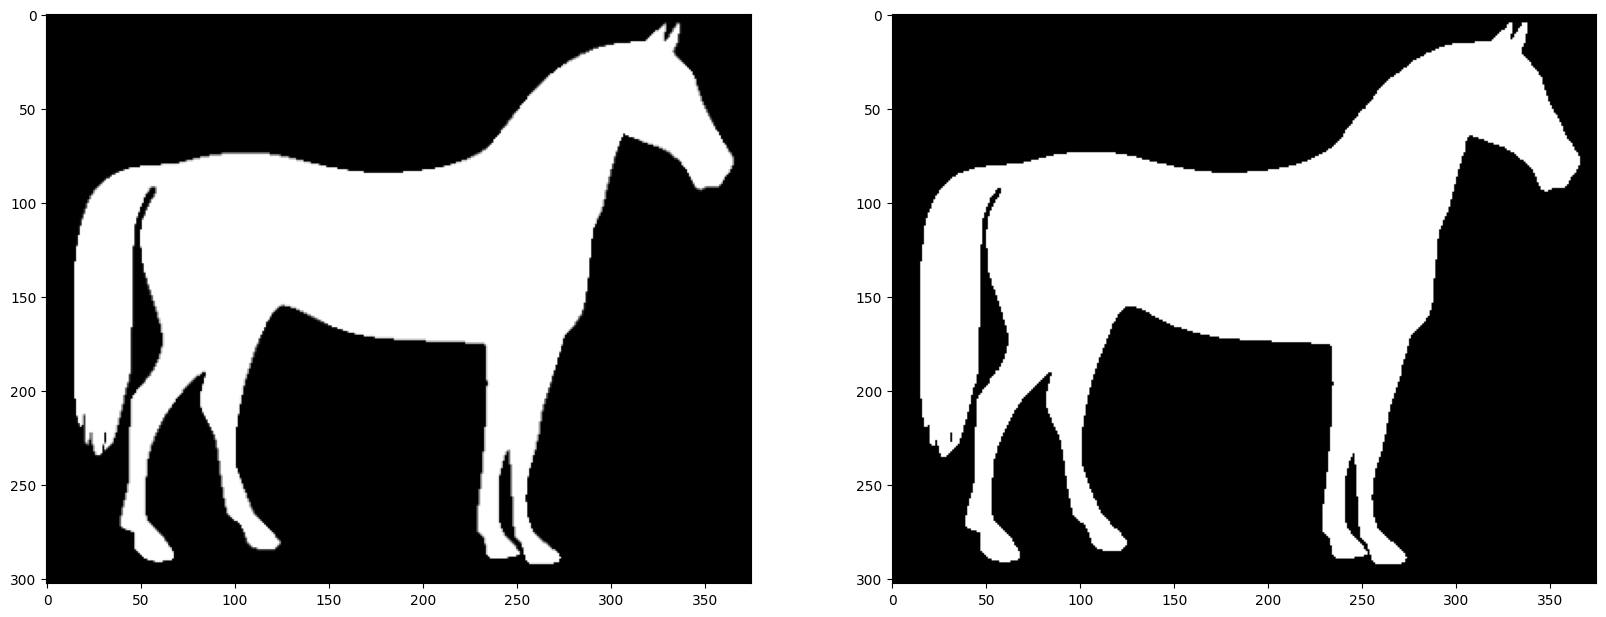

In [20]:
image = cv2.imread("./imgs/horse.png")
bw = cv2.threshold(image, 12, 255, cv2.THRESH_BINARY)[1]
bw = cv2.cvtColor(bw, cv2.COLOR_BGR2GRAY)
bw[bw > 0] = 1

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image)
ax[1].imshow(bw, cmap="gray")
plt.show()

In [37]:
def erode(img:np.ndarray,kernel:np.ndarray) -> np.ndarray:
    # verify if the kernel and img are in the same range (0-255) or (0-1)
    if(kernel.max() > 1):
        kernel = kernel / 255
    if(img.max() > 1):
        img = img / 255
    
    kernel_w = kernel.shape[0]
    kernel_h = kernel.shape[1]
    half_w = kernel_w // 2
    half_h = kernel_h // 2
    erosion = np.zeros(img.shape, np.uint8)
    kernel_center = kernel[half_w, half_h]
    
    for x in range(half_w, img.shape[0]-half_w):
        for y in range(half_h, img.shape[1]-half_h):
            # only keep what matches the kernel
            img_slice = img[x-half_w:x+half_w+1, y-half_h:y+half_h+1]
            if np.sum(img_slice * kernel) == kernel.sum():
                erosion[x,y] = kernel_center
    return erosion

def dilate(img:np.ndarray,kernel:np.ndarray) -> np.ndarray:
    if(kernel.max() > 1):
        kernel = kernel / 255
    if(img.max() > 1):
        img = img / 255
    img_shape = img.shape
    new_img = np.zeros(img_shape)
    kernel_shape = kernel.shape
    centers = [int((kernel_shape[0]-1)/2),int((kernel_shape[1]-1)/2)]
    centerx = centers[0]
    centery = centers[1]
    for x in range( centerx,img_shape[0] - centerx):
        for y in range(centery,img_shape[1] - centery):
            slice_img = img[x-centery:x+centery+1,y-centery:y+centery+1]
            does_match = (kernel * slice_img).sum() > 0
            if(does_match):
                new_img[x,y] = 255
    return new_img

def subtract(imgA:np.ndarray,imgB:np.ndarray) -> np.ndarray:
    if(imgA.shape != imgB.shape):
        raise Exception("Images must have the same shape")
    if(imgA.max() > 1):
        imgA = imgA / 255
    if(imgB.max() > 1):
        imgB = imgB / 255
    new_img = np.zeros(imgA.shape)

    for x in range(imgA.shape[0]):
        for y in range(imgA.shape[1]):
            if(imgA[x,y] != imgB[x,y]):
                new_img[x,y] = 255
    return new_img
   
def bitwise_or(imgA:np.ndarray,imgB:np.ndarray) -> np.ndarray:
    if(imgA.shape != imgB.shape):
        raise Exception("Images must have the same shape")
    if(imgA.max() == 1):
        imgA = imgA * 255
    if(imgB.max() == 1):
        imgB = imgB * 255
    new_img = np.zeros(imgA.shape)
    
    for x in range(imgA.shape[0]):
        for y in range(imgA.shape[1]):
            if(imgA[x,y] == 255 or imgB[x,y] == 255):
                new_img[x,y] = 255
    return new_img

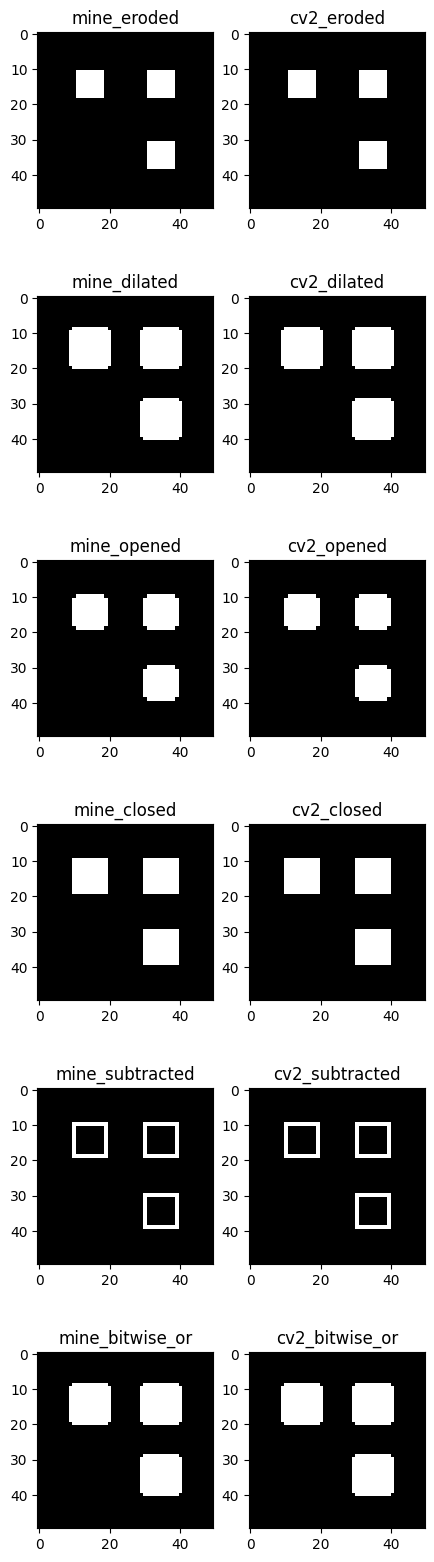

In [38]:
# tests
original = np.zeros((50,50))
# add shapes to original
original[10:20,10:20] = 255
original[30:40,30:40] = 255
original[10:20,30:40] = 255

# create kernel
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))

# erode
eroded_original = erode(original,kernel)
dilated_original = dilate(original,kernel)
opened_original = dilate(erode(original,kernel),kernel)
closed_original = erode(dilate(original,kernel),kernel)
subtracted_original = subtract(original,eroded_original)
bitwise_or_original = bitwise_or(eroded_original,dilated_original)

mine_imgs = {
    "mine_eroded":eroded_original,
    "mine_dilated":dilated_original,
    "mine_opened":opened_original,
    "mine_closed":closed_original,
    "mine_subtracted":subtracted_original,
    "mine_bitwise_or":bitwise_or_original,
}

# compare to cv2 functions
cv2_eroded = cv2.erode(original,kernel)
cv2_dilated = cv2.dilate(original,kernel)
cv2_opened = cv2.morphologyEx(original,cv2.MORPH_OPEN,kernel)
cv2_closed = cv2.morphologyEx(original,cv2.MORPH_CLOSE,kernel)
cv2_subtracted = cv2.subtract(original,cv2_eroded)
cv2_bitwise_or = cv2.bitwise_or(cv2_eroded,cv2_dilated)

cv2_imgs = {
    "cv2_eroded":cv2_eroded,
    "cv2_dilated":cv2_dilated,
    "cv2_opened":cv2_opened,
    "cv2_closed":cv2_closed,
    "cv2_subtracted":cv2_subtracted,
    "cv2_bitwise_or":cv2_bitwise_or,
}

fig, ax = plt.subplots(6, 2, figsize=(5, 20))
for i, (key, value) in enumerate(mine_imgs.items()):
    ax[i,0].imshow(value, cmap="gray")
    ax[i,0].set_title(key)
for i, (key, value) in enumerate(cv2_imgs.items()):
    ax[i,1].imshow(value, cmap="gray")
    ax[i,1].set_title(key)
plt.show()

In [42]:
def erode(img:np.ndarray,kernel:np.ndarray) -> np.ndarray:
    return cv2.erode(img, kernel, iterations = 1)

def dilate(img:np.ndarray,kernel:np.ndarray) -> np.ndarray:
    return cv2.dilate(img, kernel, iterations = 1)

def subtract(img:np.ndarray,kernel:np.ndarray) -> np.ndarray:
    return np.subtract(img, kernel)

def bitwise_or(imgA:np.ndarray,imgB:np.ndarray) -> np.ndarray:
    return np.bitwise_or(imgA, imgB)

In [39]:
def generate_skeleton_img(img:np.ndarray,element:np.ndarray) -> np.ndarray:
    """
    Generate a skeleton image from a binary image.
    """
    skeleton = np.zeros(img.shape, np.uint8)
    size = np.size(img)
    if element is None:
        element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    done = False
    while(not done):
        eroded = erode(img, element)
        temp = dilate(eroded, element)
        temp = subtract(img, temp)
        skeleton = bitwise_or(skeleton, temp)
        img = eroded.copy()
        zeros = size - cv2.countNonZero(img)
        if zeros == size:
            done = True
    return skeleton

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


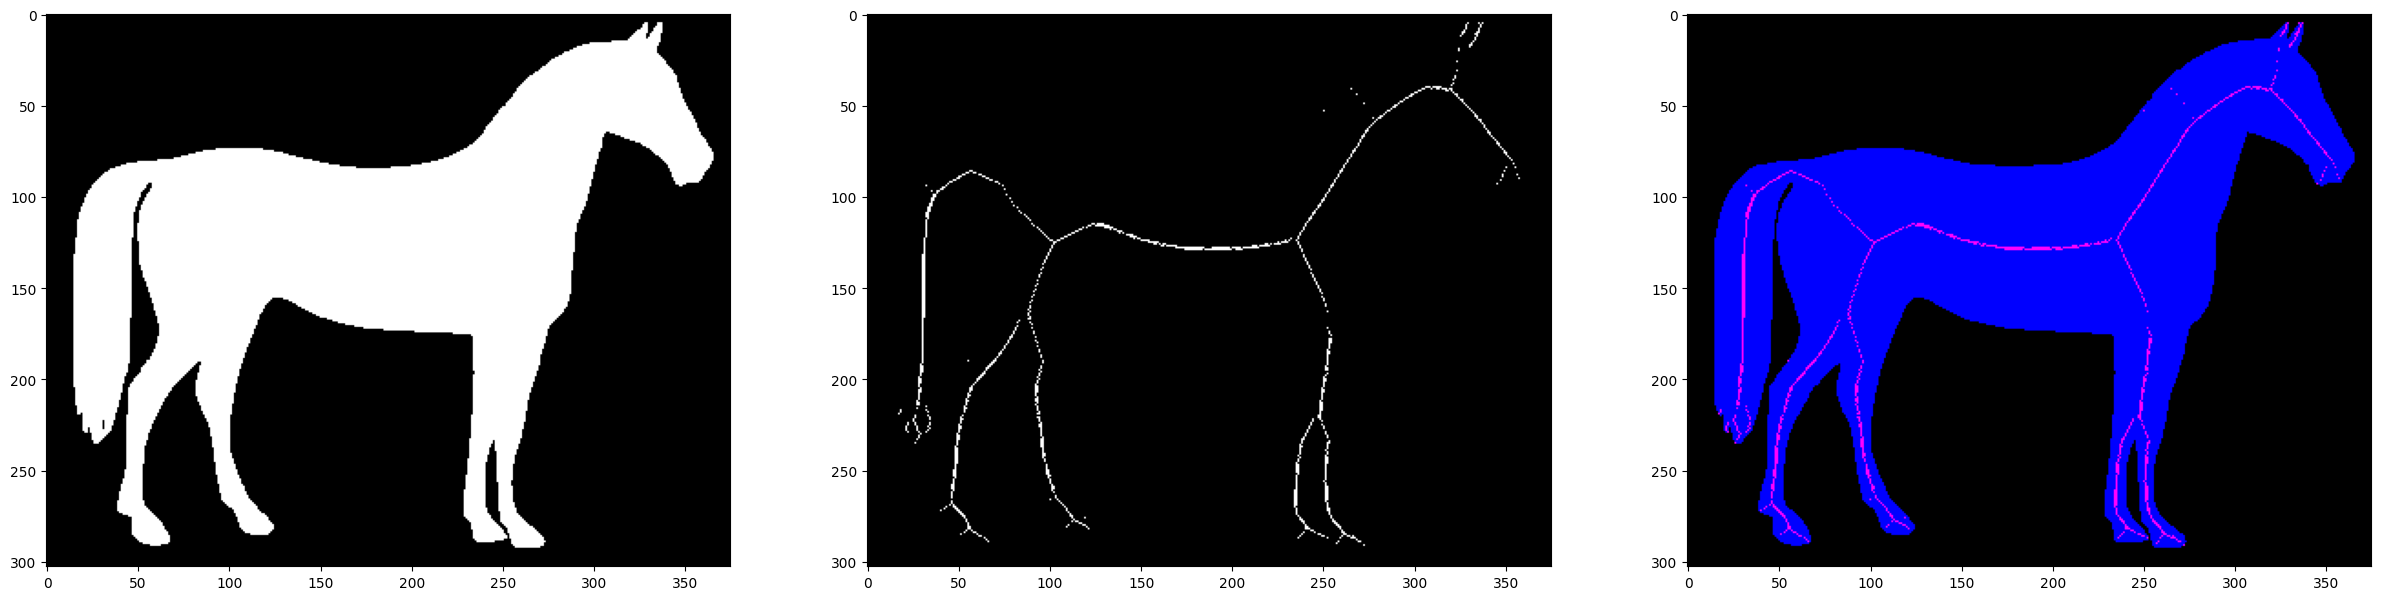

In [46]:
skeleton = generate_skeleton_img(bw,None)
new_rgb = np.zeros(image.shape)
new_rgb[:,:,0] = skeleton

# add the original image to the skeleton
new_rgb[:,:,2] += image[:,:,2]

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(bw, cmap="gray")
ax[1].imshow(skeleton, cmap="gray")
ax[2].imshow(new_rgb)
plt.show()